In [61]:
# SPDX-FileCopyrightText: 2024 Universidad Autónoma de Madrid, Madrid (Spain)
# SPDX-License-Identifier: EUPL-1.2

"""
This script performs step-by-step calibration of hyperspectral images.
The user can process one hyperspectral image directory at a time.

Written by: Claudia Fournier
Revised date: 24.10.2024
"""

'\nThis script performs step-by-step calibration of hyperspectral images.\nThe user can process one hyperspectral image directory at a time.\n\nWritten by: Claudia Fournier\nRevised date: 24.10.2024\n'

# Load the libraries

In [76]:
# Load the libraries
from spectral import open_image, imshow  # For handling hyperspectral images
import matplotlib.pyplot as plt           # For plotting and visualization
import numpy as np                        # For numerical operations
import os                                 # For file path and directory handling
from scipy.ndimage import zoom            # For image zooming and resizing

# Load the data

In [65]:
# Set the path relative to the project root
base_path = os.path.abspath(os.path.join(os.getcwd(), '..')) 

def load_hyperspectral_image(path):
    """Load a hyperspectral image using the spectral library."""
    return spectral.open_image(path).load()

# Data location
raw_image_path = os.path.join(base_path, "data/003/capture/003.hdr")
white_ref_path = os.path.join(base_path, "data/003/capture/WHITEREF_003.hdr")
dark_ref_path = os.path.join(base_path, "data/003/capture/DARKREF_003.hdr")

# Load images
raw_image = load_hyperspectral_image(raw_image_path)
white_ref = load_hyperspectral_image(white_ref_path)
dark_ref = load_hyperspectral_image(dark_ref_path)

# Exploration

In [66]:
# Check the dimensions (rows, columns, wavelengths) of the white reference, dark reference, and raw image
print(f'White reference has {white_ref.shape[0]} rows, {white_ref.shape[1]} columns, and {white_ref.shape[2]} wavelengths')
print(f'Dark reference has {dark_ref.shape[0]} rows, {dark_ref.shape[1]} columns, and {dark_ref.shape[2]} wavelengths')
print(f'Raw image has {raw_image.shape[0]} rows, {raw_image.shape[1]} columns, and {raw_image.shape[2]} wavelengths')

White reference has 1 rows, 512 columns, and 204 wavelengths
Dark reference has 1 rows, 512 columns, and 204 wavelengths
Raw image has 512 rows, 512 columns, and 204 wavelengths


In [72]:
# Check the metadata of the raw image
print("Metadata keys available:", raw_image.metadata.keys())

print("\nSample of wavelength content:")
print(raw_image.metadata['wavelength'])

Metadata keys available: dict_keys(['description', 'samples', 'lines', 'bands', 'header offset', 'file type', 'data type', 'interleave', 'sensor type', 'byte order', 'default bands', 'latitude', 'longitude', 'acquisition date', 'errors', 'binning', 'tint', 'fps', 'wavelength'])

Sample of wavelength content:
['397.32', '400.20', '403.09', '405.97', '408.85', '411.74', '414.63', '417.52', '420.40', '423.29', '426.19', '429.08', '431.97', '434.87', '437.76', '440.66', '443.56', '446.45', '449.35', '452.25', '455.16', '458.06', '460.96', '463.87', '466.77', '469.68', '472.59', '475.50', '478.41', '481.32', '484.23', '487.14', '490.06', '492.97', '495.89', '498.80', '501.72', '504.64', '507.56', '510.48', '513.40', '516.33', '519.25', '522.18', '525.10', '528.03', '530.96', '533.89', '536.82', '539.75', '542.68', '545.62', '548.55', '551.49', '554.43', '557.36', '560.30', '563.24', '566.18', '569.12', '572.07', '575.01', '577.96', '580.90', '583.85', '586.80', '589.75', '592.70', '595.65',

In [54]:
# Finding the positions of specific wavelengths (650 nm, 550 nm, 450 nm) in the metadata for RGB displaying
positions = {wavelength: min(range(len(raw_image.metadata['wavelength'])), key=lambda i: abs(float(raw_image.metadata['wavelength'][i]) - wavelength)) for wavelength in [650, 550, 450]}
print(positions)

{650: 86, 550: 52, 450: 18}


ImageView object:
  Display bands       :  (86, 52, 18)
  Interpolation       :  <default>
  RGB data limits     :
    R: [244.0, 4095.0]
    G: [244.0, 4095.0]
    B: [243.0, 4095.0]

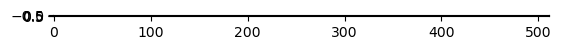

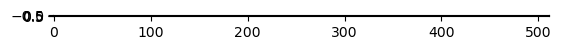

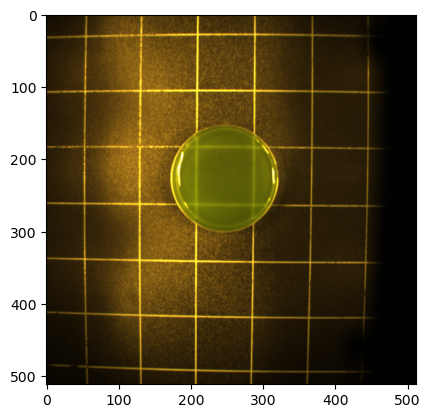

In [74]:
# Displaying references and raw image using RGB bands

imshow(white_ref, (86, 52, 18))
imshow(dark_ref, (86, 52, 18))
imshow(raw_image, (86, 52, 18))

# Resizing

Resized white reference to 512 rows, 512 columns, and 204 wavelengths
Resized dark reference to 512 rows, 512 columns, and 204 wavelengths


ImageView object:
  Display bands       :  (86, 52, 18)
  Interpolation       :  <default>
  RGB data limits     :
    R: [244.0, 4095.0]
    G: [244.0, 4095.0]
    B: [243.0, 4095.0]

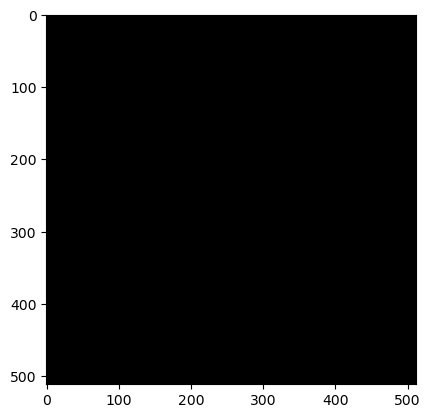

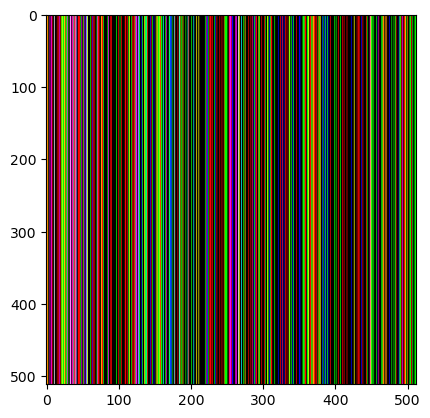

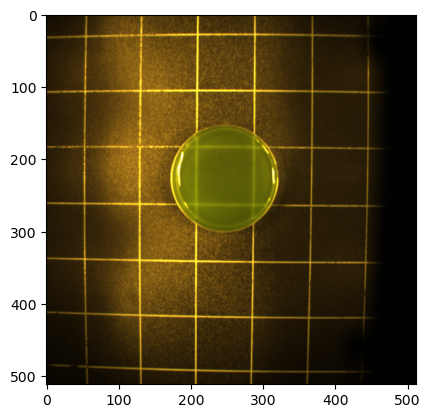

In [77]:
def resize_hyperspectral_image(image, target_shape):
    """
    Resize a hyperspectral image to match the target shape.
    
    Args:
        image (numpy.ndarray): The hyperspectral image to resize.
        target_shape (tuple): The target shape (rows, columns, wavelengths).
        
    Returns:
        numpy.ndarray: The resized hyperspectral image.
    """
    factors = (
        target_shape[0] / image.shape[0],  # Factor for rows
        target_shape[1] / image.shape[1],  # Factor for columns
        1  # No resizing in the wavelength dimension
    )
    return zoom(image, factors, order=1)  # Use bilinear interpolation for resizing

# Resizing white and dark references if their shapes don't match the raw image
if white_ref.shape != raw_image.shape:
    white_ref = resize_hyperspectral_image(white_ref, raw_image.shape)
    print(f'Resized white reference to {white_ref.shape[0]} rows, {white_ref.shape[1]} columns, and {white_ref.shape[2]} wavelengths')

if dark_ref.shape != raw_image.shape:
    dark_ref = resize_hyperspectral_image(dark_ref, raw_image.shape)
    print(f'Resized dark reference to {dark_ref.shape[0]} rows, {dark_ref.shape[1]} columns, and {dark_ref.shape[2]} wavelengths')

# Display the resized white reference, dark reference, and raw image
imshow(white_ref, (positions[650], positions[550], positions[450]))
imshow(dark_ref, (positions[650], positions[550], positions[450]))
imshow(raw_image, (positions[650], positions[550], positions[450]))

# Applying calibration equation

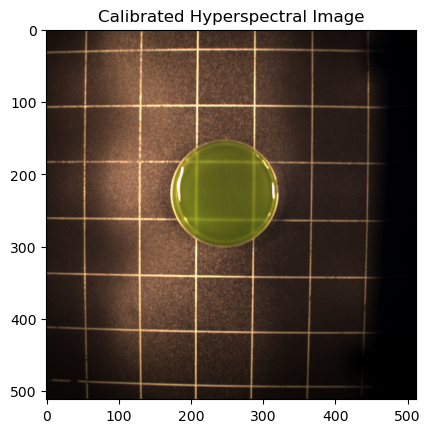

In [79]:
def apply_calibration(raw_image, white_ref, dark_ref):
    """
    Apply the calibration equation to the raw hyperspectral image.
    This corrects the raw image using the white and dark reference values.
    
    Args:
        raw_image (numpy.ndarray): The raw hyperspectral image.
        white_ref (numpy.ndarray): The white reference image.
        dark_ref (numpy.ndarray): The dark reference image.
    
    Returns:
        numpy.ndarray: The calibrated hyperspectral image with values clipped between 0 and 1.
    """
    # Apply calibration equation
    calibrated_image = (raw_image - dark_ref) / (white_ref - dark_ref)
    
    # Clip values to valid range [0, 1]
    calibrated_image = np.clip(calibrated_image, 0, 1)
    
    return calibrated_image

# Apply calibration
calibrated_image = apply_calibration(raw_image, white_ref, dark_ref)

# Display the calibrated image using RGB bands
imshow(calibrated_image, (positions[650], positions[550], positions[450]))
plt.title('Calibrated Hyperspectral Image')
plt.show()